In [1]:
import os
import sys
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

In [2]:
sys.path.append("../../src")
import main

In [3]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_wmean', 'StrClo400_median']

In [133]:
def calc_overlaps_area(gdf):
    gdf['index'] = gdf.index
    # Spatial join: each polygon matched with polygons it intersects
    joined = gpd.sjoin(gdf, gdf, how="inner", predicate='intersects')

    # Remove self-intersections (where the same polygon joins itself)
    joined = joined[joined.index_left != joined.index_right]

    overlap_geoms = []
    for idx in joined.index_left.unique():
        others = gdf.loc[joined[joined.index_left == idx].index_right]
        intersection = gdf.loc[idx].geometry.intersection(others.unary_union)
        if not intersection.is_empty:
            overlap_geoms.append(intersection)
        
    #Merge all overlaps into one
    if overlap_geoms:
        overlaps = gpd.GeoSeries(overlap_geoms).unary_union
        overlap_area = overlaps.area
    else:
        overlap_area = 0

    total_area = gdf.area.sum()
    union_area = gdf.unary_union.area

    fraction_overlap = overlap_area / total_area
    overlap_union = overlap_area / union_area
    fraction_union = union_area / total_area
    
    return overlap_area, total_area, fraction_overlap, overlap_union, fraction_union

<Axes: >

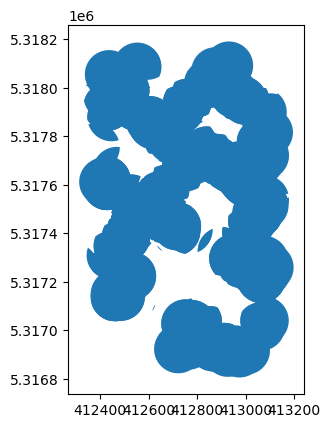

In [106]:
gpd.GeoSeries(overlap_geoms).cx[412500:413000,5317000:5318000].plot()

In [5]:
radii = [30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,320,340,360,380,400,450,500,600,700,800,900,1000,1100,1200,1500,2000]

stats = {}

for radius in radii:
    print(radius)
    gdf = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_processed_station_params_' + str(radius) + '.parquet')
    stats[radius] = {}

    """
    overlap_area, total_area, fraction_overlap, overlap_union, fraction_union = calc_overlaps_area(gdf)
    stats[radius]['overlap_area'] = overlap_area
    stats[radius]['total_area'] = total_area
    stats[radius]['fraction_overlap'] = fraction_overlap
    stats[radius]['overlap_union'] = overlap_union
    stats[radius]['fraction_union'] = fraction_union
    """
    


    for var in ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_wmean', 'StrClo400_median']:
        print(var)
        # drop nan values
        gdf_s = gdf.dropna(subset=[var, 'Temperature_diff_K'])

        # drop rows with 0 values
        if var in ['BuVol_3D_sum', 'BuEWA_3D_sum', 'BuSWR_3D_median', 'BuHt_wmean', 'BuERI_wmean']:
            gdf_s = gdf_s[gdf_s[var] > 0]

        stats[radius][var+'_std'] = gdf_s[var].std()
        stats[radius][var+'_mean'] = gdf_s[var].mean()
        stats[radius][var+'_CV'] = gdf_s[var].std()/gdf_s[var].mean()

        stats[radius][var+'_spearman_corr'], stats[radius][var+'_spearman_p_value'] = spearmanr(gdf_s[var],gdf_s['Temperature_diff_K'])

        # Pearson and r squared
        stats[radius][var+'_pearson_corr'], stats[radius][var+'_pearson_p_value'] = pearsonr(gdf_s[var], gdf_s['Temperature_diff_K'])
        X = sm.add_constant(gdf_s[var])  # Add constant for regression
        model = sm.OLS(gdf_s['Temperature_diff_K'], X).fit()
        r_squared = model.rsquared
        stats[radius][var+'_rsquared'] = r_squared

        # Get the predicted values (fitted values)
        y_pred = model.fittedvalues

        # Calculate the residuals (errors)
        residuals = gdf_s['Temperature_diff_K'] - y_pred

        # Calculate the least squares error (RSS)
        rss = np.sum(residuals ** 2)
        # Calculate the Mean Squared Error (MSE)
        mse = rss / len(gdf_s[var])
        # Calculate the Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)
        stats[radius][var+'_rmse'] = rmse

        # Compute Cook's distance
        influence = model.get_influence()
        cooks_d = influence.cooks_distance[0].max()  # Max Cook's distance
        stats[radius][var+'_cooks_d'] = cooks_d

        stats[radius][var+'_mi'] = mutual_info_regression(gdf_s[[var]], gdf_s['Temperature_diff_K'])

    # Multiple Linear Regression
    stn_nona = gdf.dropna(subset=params)
    X = stn_nona[params]
    y = stn_nona['Temperature_diff_K']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # perform linear regression
    X_train = sm.add_constant(X_train)  # Add constant for regression
    model = sm.OLS(y_train, X_train).fit()
    stats[radius]['MLR_rsquared'] = model.rsquared
    stats[radius]['MLR_fvalue'] = model.fvalue
    stats[radius]['MLR_f_pvalue'] = model.f_pvalue

    # print r squared for test set
    X_test = sm.add_constant(X_test)  # Add constant for regression
    y_pred = model.predict(X_test)
    r2_MLR = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
    stats[radius]['MLR_test_rsquared'] = r2_MLR

    # Lasso regression
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train)

    y_pred = lasso.predict(X_test)
    r2_lasso = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
    stats[radius]['lasso_rsquared'] = r2_lasso
    
pd.DataFrame(stats).T.to_csv('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_stats_scales.csv')

30
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuERI_wmean
StrClo400_median
40
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuERI_wmean
StrClo400_median
50
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuERI_wmean
StrClo400_median
60
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuERI_wmean
StrClo400_median
70
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuERI_wmean
StrClo400_median
80
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuERI_wmean
StrClo400_median
90
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuERI_wmean
StrClo400_median
100
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wme

In [6]:
df = pd.DataFrame(stats).T

In [6]:
df = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_stats_scales.csv', index_col=0)

In [8]:
df

,BuAre_sum_std,BuAre_sum_mean,BuAre_sum_CV,BuAre_sum_spearman_corr,BuAre_sum_spearman_p_value,BuAre_sum_pearson_corr,BuAre_sum_pearson_p_value,BuAre_sum_rsquared,BuAre_sum_rmse,BuAre_sum_cooks_d,...,StrClo400_median_pearson_p_value,StrClo400_median_rsquared,StrClo400_median_rmse,StrClo400_median_cooks_d,StrClo400_median_mi,MLR_rsquared,MLR_fvalue,MLR_f_pvalue,MLR_test_rsquared,lasso_rsquared
30,369.092412,553.516968,0.666813,0.298861,0.0,0.29744,0.0,0.08847,1.457113,0.04826,...,0.0,0.108454,1.389481,0.011331,[0.6104426985187659],0.173374,1.658833,0.096637,0.035403,0.078095
40,621.440735,916.713024,0.677901,0.32442,0.0,0.328104,0.0,0.107652,1.465382,0.035366,...,0.0,0.095412,1.363589,0.008351,[0.7126215461585415],0.288384,20.188953,0.0,0.279893,0.235473
50,987.586272,1409.903062,0.700464,0.357863,0.0,0.356919,0.0,0.127391,1.461658,0.023638,...,0.0,0.105473,1.41897,0.006266,[0.768814069987747],0.239069,31.360905,0.0,0.28763,0.226262
60,1385.522911,2016.837119,0.686978,0.382237,0.0,0.381986,0.0,0.145913,1.444983,0.023912,...,0.0,0.104586,1.419639,0.005639,[0.7888929031939345],0.274939,54.60389,0.0,0.231306,0.208675
70,1882.435569,2732.522702,0.6889,0.411989,0.0,0.404527,0.0,0.163642,1.45613,0.007474,...,0.0,0.098437,1.413832,0.005722,[0.8012226140962246],0.26385,65.818648,0.0,0.201854,0.172229
80,2411.193329,3573.559558,0.674732,0.452406,0.0,0.442577,0.0,0.195875,1.44019,0.010303,...,0.0,0.099013,1.426641,0.005113,[0.8309963728904357],0.279149,83.575279,0.0,0.280347,0.252624
90,3055.675505,4536.037869,0.673644,0.491599,0.0,0.475967,0.0,0.226544,1.430608,0.009079,...,0.0,0.101536,1.437332,0.005223,[0.7880296361879324],0.265395,86.673316,0.0,0.322579,0.294547
100,3783.029271,5622.68136,0.672816,0.512764,0.0,0.493494,0.0,0.243536,1.418785,0.010638,...,0.0,0.099113,1.450743,0.004993,[0.7604730718513926],0.294245,107.300586,0.0,0.314877,0.304877
110,4529.780164,6759.866857,0.670099,0.532891,0.0,0.510434,0.0,0.260543,1.410785,0.010639,...,0.0,0.100528,1.449538,0.005128,[0.7953214271124613],0.309117,121.211132,0.0,0.33457,0.311258
120,5329.109252,8018.271627,0.664621,0.550614,0.0,0.529498,0.0,0.280368,1.401107,0.008478,...,0.0,0.103884,1.456081,0.005341,[0.7999028167347362],0.337338,143.509911,0.0,0.313386,0.297965


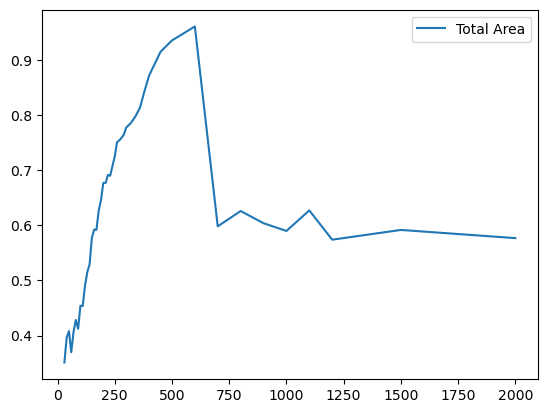

In [9]:
plt.plot(df.index, df['BuAre_sum_mi'], label='Total Area')
plt.legend()

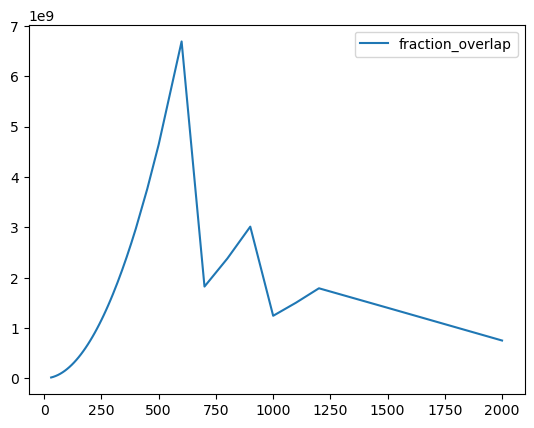

In [138]:
plt.plot(df.index, df['total_area'], label='Total Area')
plt.legend()

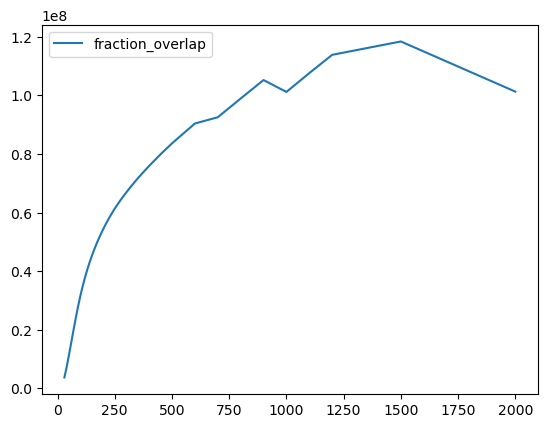

In [137]:
plt.plot(df.index, df['overlap_area'], label='fraction_overlap')
plt.legend()

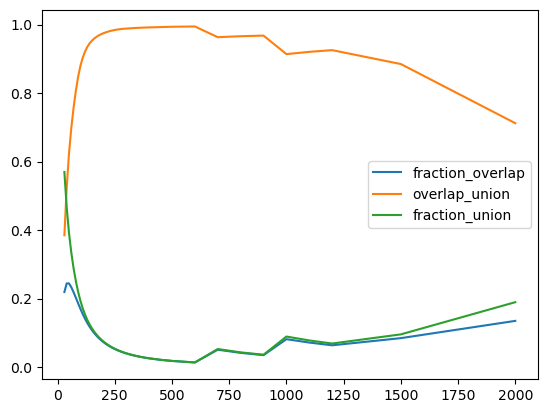

In [132]:
plt.plot(df.index, df['fraction_overlap'], label='fraction_overlap')
plt.plot(df.index, df['overlap_union'], label='overlap_union')
plt.plot(df.index, df['fraction_union'], label='fraction_union')
plt.legend()

Doesn't work because my sample size is not consistent! At higher radii I choose less meteobike data points to calculate so overlap will be less as I select data points which are further away from each other

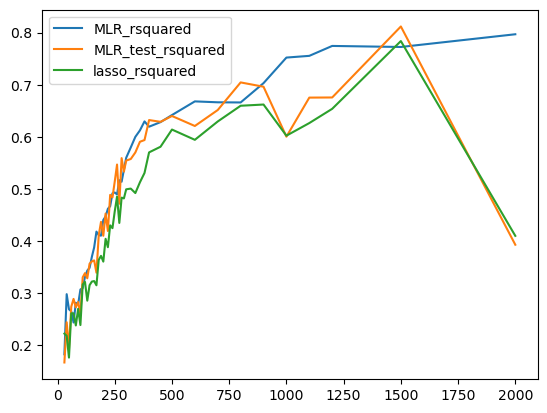

In [151]:
plt.plot(df.index, df['MLR_rsquared'], label='MLR_rsquared')
plt.plot(df.index, df['MLR_test_rsquared'], label='MLR_test_rsquared')
plt.plot(df.index, df['lasso_rsquared'], label='lasso_rsquared')
plt.legend()

In [142]:
df['BuAre_sum_mean'] = df['BuAre_sum_mean'] / df.index**2*np.pi
df['BuAre_sum_std'] = df['BuAre_sum_std'] / df.index**2*np.pi

In [143]:
df['BuEWA_3D_sum_mean'] = df['BuEWA_3D_sum_mean'] / (df.index**2*np.pi)
df['BuEWA_3D_sum_std'] = df['BuEWA_3D_sum_std'] / (df.index**2*np.pi)

In [144]:
df["BuVol_3D_sum_mean"] = df["BuVol_3D_sum_mean"] / (df.index**2*np.pi)
df["BuVol_3D_sum_std"] = df["BuVol_3D_sum_std"] / (df.index**2*np.pi)

In [145]:
# standardise columns ending in _mean between 0 and 1
def standardize_column(df, column_name):
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)
    return df

for col in df.columns:
    if col.endswith('_mean'):
        df = standardize_column(df, col)
    if col.endswith('_std'):
        df = standardize_column(df, col)

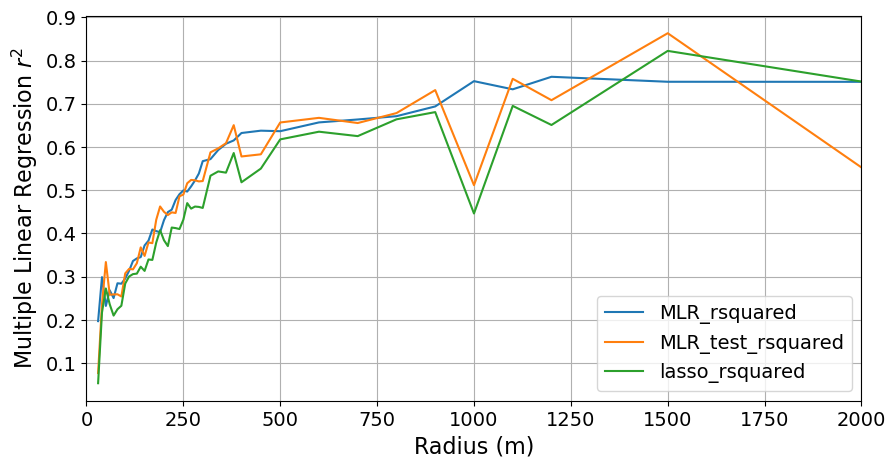

In [10]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['MLR_rsquared'], label='MLR_rsquared')
plt.plot(df.index, df['MLR_test_rsquared'], label='MLR_test_rsquared')
plt.plot(df.index, df['lasso_rsquared'], label='lasso_rsquared')
plt.grid()
plt.xlabel('Radius (m)',fontsize=16)
plt.ylabel('Multiple Linear Regression $r^2$',fontsize=16)
plt.xlim(0,2000)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=14)
plt.savefig('/Users/lisawink/Documents/paper1/figures/MLR_rsquared.png', dpi=300)
plt.show()

In [54]:
# for every p value greater than  0.05, make spearman correlation value nan in each row of the df

for i in params:
    # If the p-value column is greater than 0.05, set the correlation column to NaN
    df.loc[df[i + '_spearman_p_value'] > 0.05, i + '_spearman_corr'] = np.nan

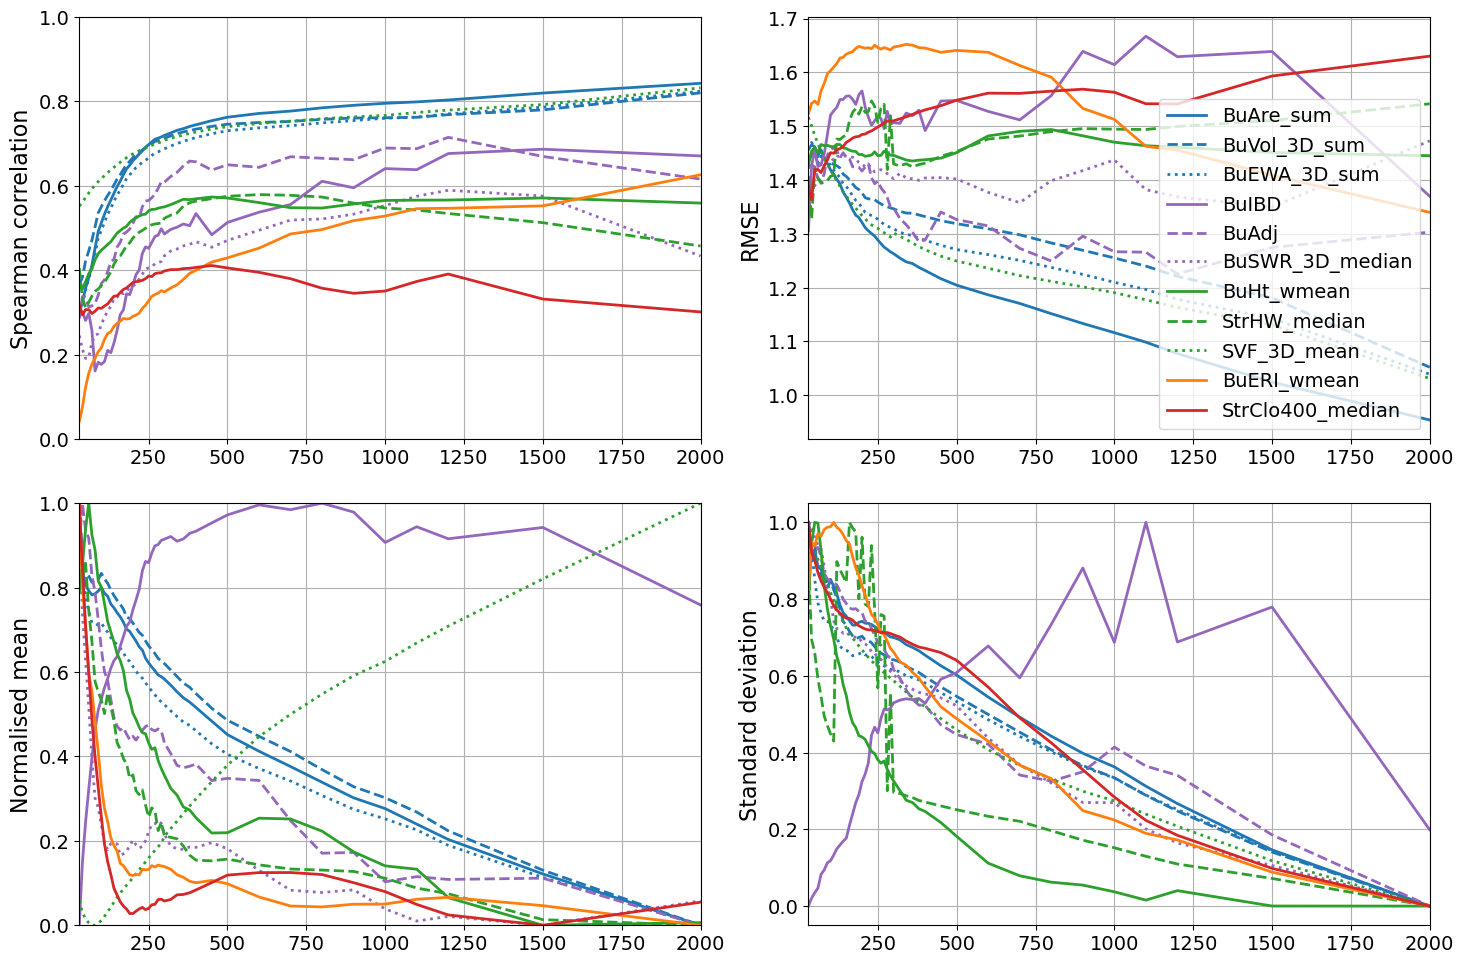

In [146]:
fig, axs = plt.subplots(2,2, figsize=(15, 10))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuERI_wmean': '-',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'BuERI_wmean': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for var in params:
    axs[0, 0].plot(abs(df[var+'_spearman_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=16)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)
axs[0, 0].grid()

for var in params:
    axs[0, 1].plot(df[var+'_rmse'], label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 1].set_ylabel("RMSE", fontsize=16)
axs[0, 1].legend(prop={'size': 14})
#axs[0, 1].set_ylim(0, 0.0000001)
axs[0, 1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)
axs[0, 1].grid()

for var in params:
    axs[1, 0].plot(abs(df[var+'_mean']), label=var, linestyle=linestyle_mapping[var], linewidth=2,color=color_mapping[var])
axs[1, 0].set_ylabel('Normalised mean', fontsize=16)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(30, 2000)
#axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)
axs[1, 0].grid()

for var in params:
    axs[1, 1].plot(df[var+'_std'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[1, 1].set_ylabel('Standard deviation', fontsize=16)
axs[1, 1].grid()
#axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(30, 2000)
#axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)


plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/mbike270623_param_scale_plot_featured_list_new.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/mbike270623_param_scale_plot_featured_list_new.pdf')
plt.show()

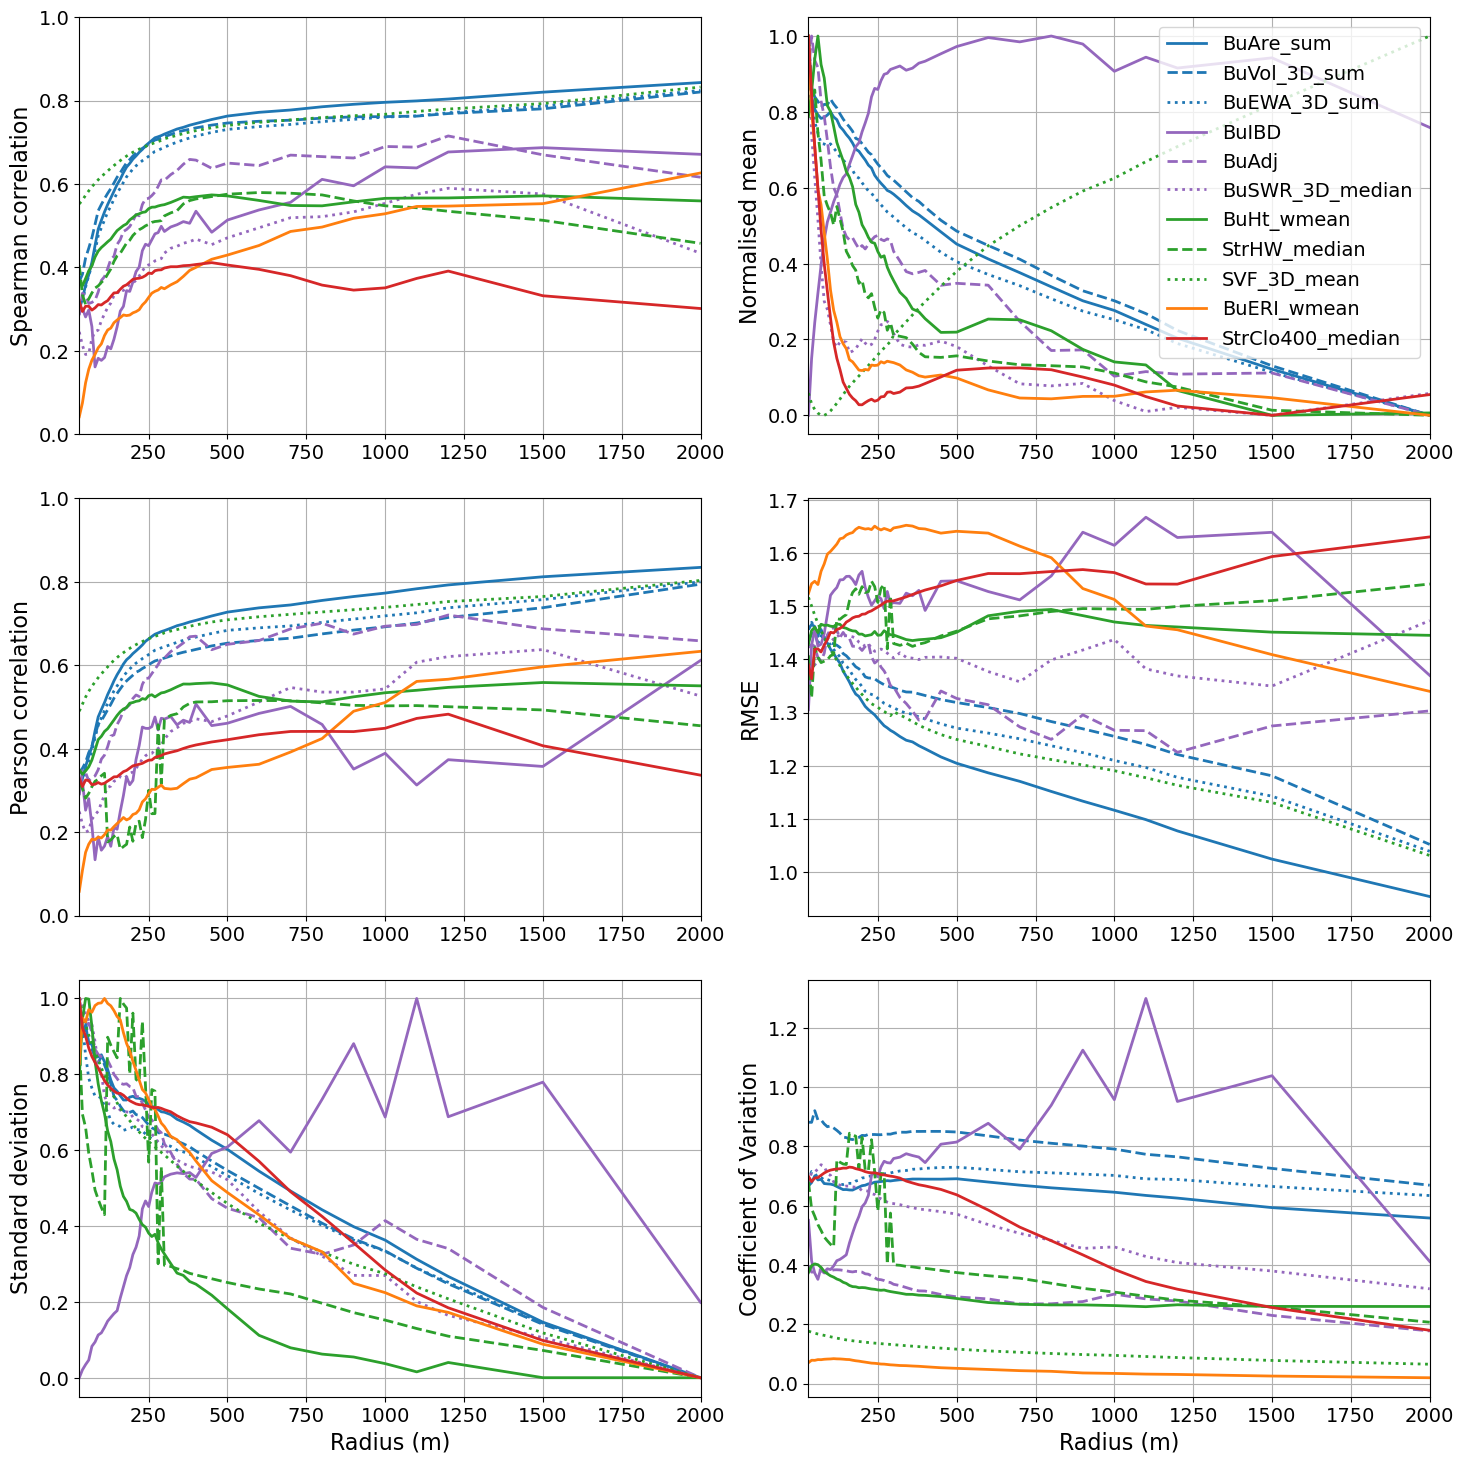

In [71]:
fig, axs = plt.subplots(3,2, figsize=(15, 15))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuERI_wmean': '-',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'BuERI_wmean': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for var in params:
    axs[0, 0].plot(abs(df[var+'_spearman_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=16)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)
axs[0, 0].grid()

for var in params:
    axs[0, 1].plot(df[var+'_rmse'], label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 1].set_ylabel("RMSE", fontsize=16)
axs[0, 1].legend(prop={'size': 14})
#axs[0, 1].set_ylim(0, 0.0000001)
axs[0, 1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)
axs[0, 1].grid()

for var in params:
    axs[1, 0].plot(abs(df[var+'_mean']), label=var, linestyle=linestyle_mapping[var], linewidth=2,color=color_mapping[var])
axs[1, 0].set_ylabel('Normalised mean', fontsize=16)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(30, 2000)
#axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)
axs[1, 0].grid()

for var in params:
    axs[1, 1].plot(df[var+'_std'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[1, 1].set_ylabel('Standard deviation', fontsize=16)
axs[1, 1].grid()
#axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(30, 2000)
#axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)

for var in params:
    axs[2, 0].plot(df[fraction_union], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[2, 0].set_ylabel("Unique area", fontsize=16)
#axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].set_xlim(30, 2000)
axs[2, 0].set_xlabel('Radius (m)', fontsize=16)
axs[2, 0].tick_params(axis='both', which='major', labelsize=14)
axs[2, 0].grid()

axs[2, 1].plot(df.index, df['MLR_rsquared'], label='MLR_rsquared')
axs[2, 1].plot(df.index, df['MLR_test_rsquared'], label='MLR_test_rsquared')
axs[2, 1].plot(df.index, df['lasso_rsquared'], label='lasso_rsquared')
axs[2, 1].set_ylabel("Multiple Linear Regression $r^2$", fontsize=16)
#axs[2, 1].set_ylim(0, 2)
axs[2, 1].set_xlim(30, 2000)
axs[2, 1].set_xlabel('Radius (m)', fontsize=16)
axs[2, 1].tick_params(axis='both', which='major', labelsize=14)
axs[2, 1].grid()

plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/mbike270623_param_scale_plot_featured_list_new.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/mbike270623_param_scale_plot_featured_list_new.pdf')
plt.show()

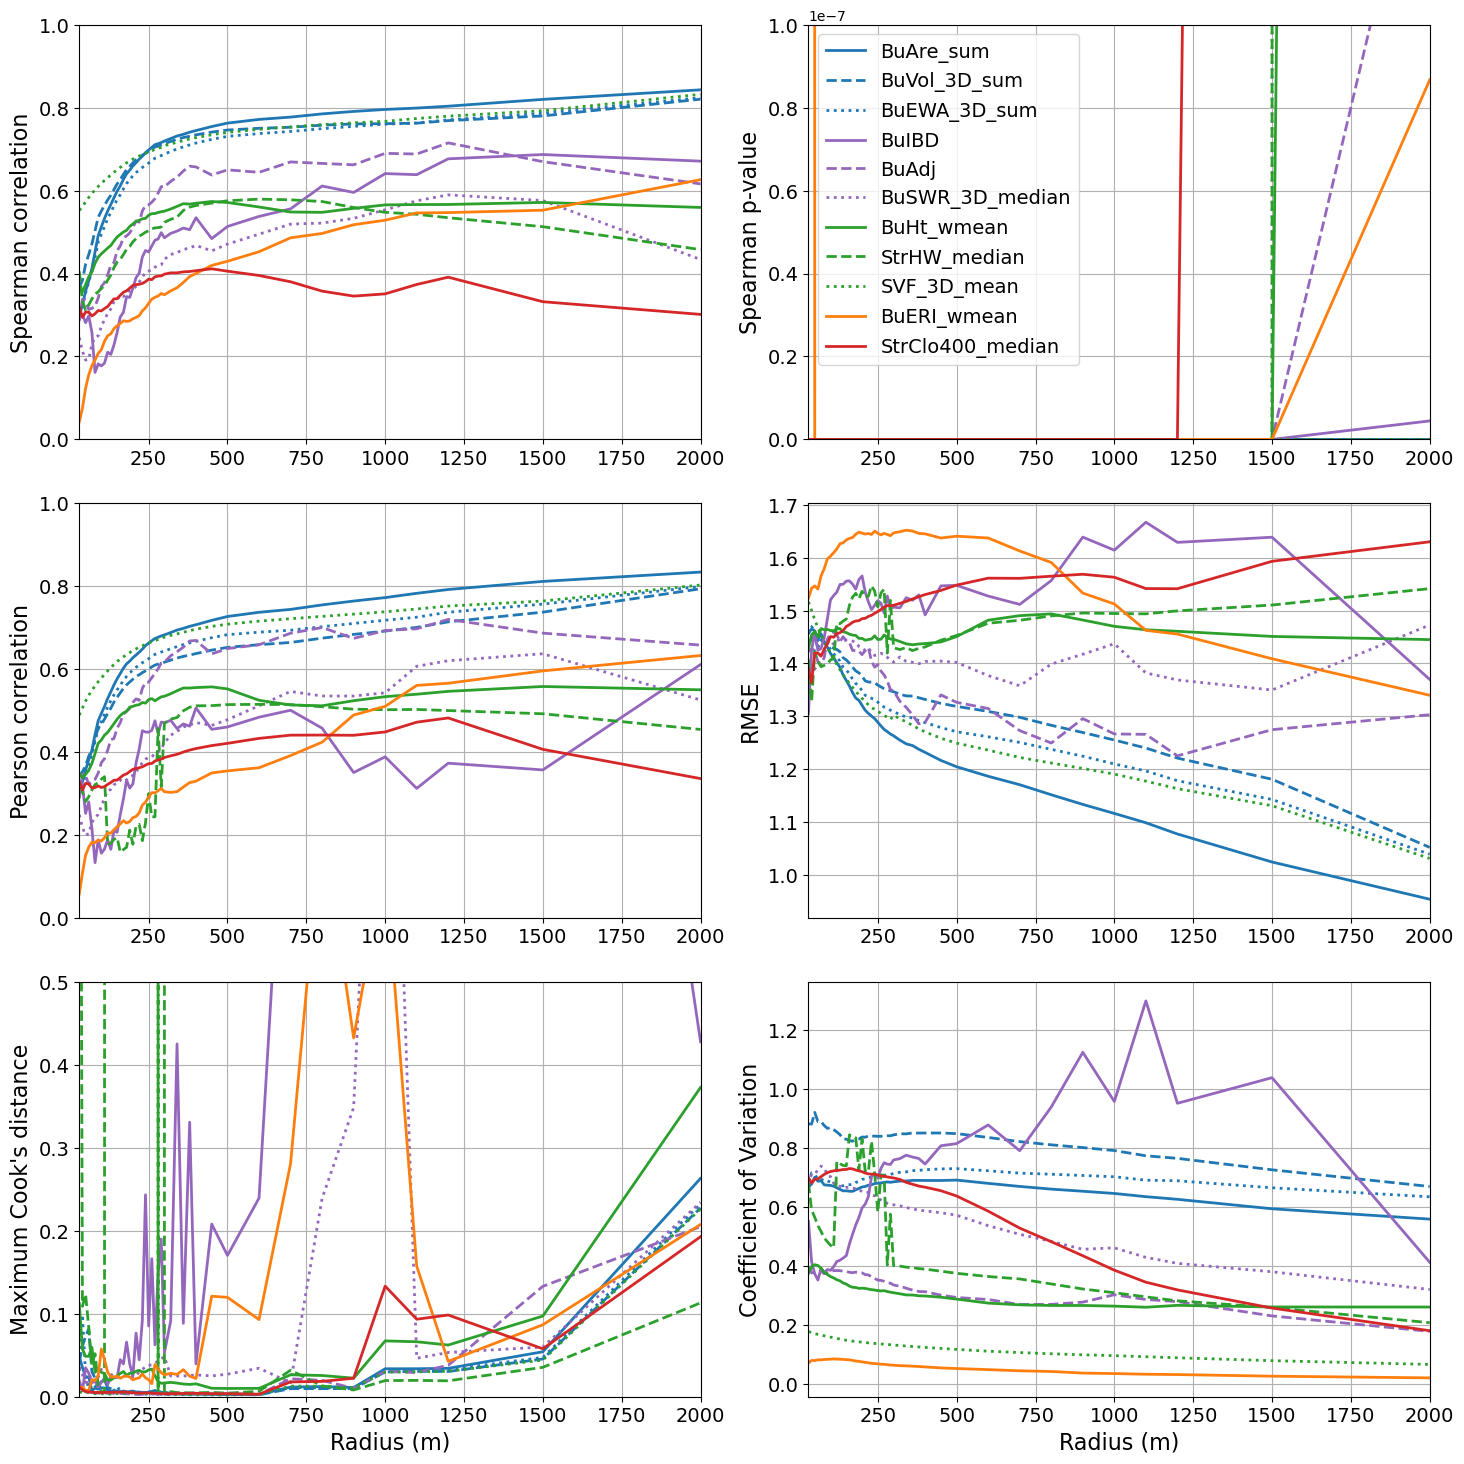

In [147]:
df = pd.DataFrame(stats).T
fig, axs = plt.subplots(3,2, figsize=(15, 15))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuERI_wmean': '-',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'BuERI_wmean': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for var in params:
    axs[0, 0].plot(abs(df[var+'_spearman_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=16)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)
axs[0, 0].grid()

for var in params:
    axs[0, 1].plot(df[var+'_spearman_p_value'], label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 1].set_ylabel("Spearman p-value", fontsize=16)
axs[0, 1].legend(prop={'size': 14})
axs[0, 1].set_ylim(0, 0.0000001)
axs[0, 1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)
axs[0, 1].grid()

for var in params:
    axs[1, 0].plot(abs(df[var+'_pearson_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2,color=color_mapping[var])
axs[1, 0].set_ylabel('Pearson correlation', fontsize=16)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(30, 2000)
#axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)
axs[1, 0].grid()

for var in params:
    axs[1, 1].plot(df[var+'_rmse'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[1, 1].set_ylabel('RMSE', fontsize=16)
axs[1, 1].grid()
#axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(30, 2000)
#axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)

for var in params:
    axs[2, 0].plot(df[var+'_cooks_d'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[2, 0].set_ylabel("Maximum Cook's distance", fontsize=16)
axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].set_xlim(30, 2000)
axs[2, 0].set_xlabel('Radius (m)', fontsize=16)
axs[2, 0].tick_params(axis='both', which='major', labelsize=14)
axs[2, 0].grid()

for var in params:
    axs[2, 1].plot(df[var+'_CV'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[2, 1].set_ylabel("Coefficient of Variation", fontsize=16)
#axs[2, 1].set_ylim(0, 2)
axs[2, 1].set_xlim(30, 2000)
axs[2, 1].set_xlabel('Radius (m)', fontsize=16)
axs[2, 1].tick_params(axis='both', which='major', labelsize=14)
axs[2, 1].grid()

plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/mbike270623_param_scale_plot_featured_list.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/mbike270623_param_scale_plot_featured_list.pdf')
plt.show()

2000


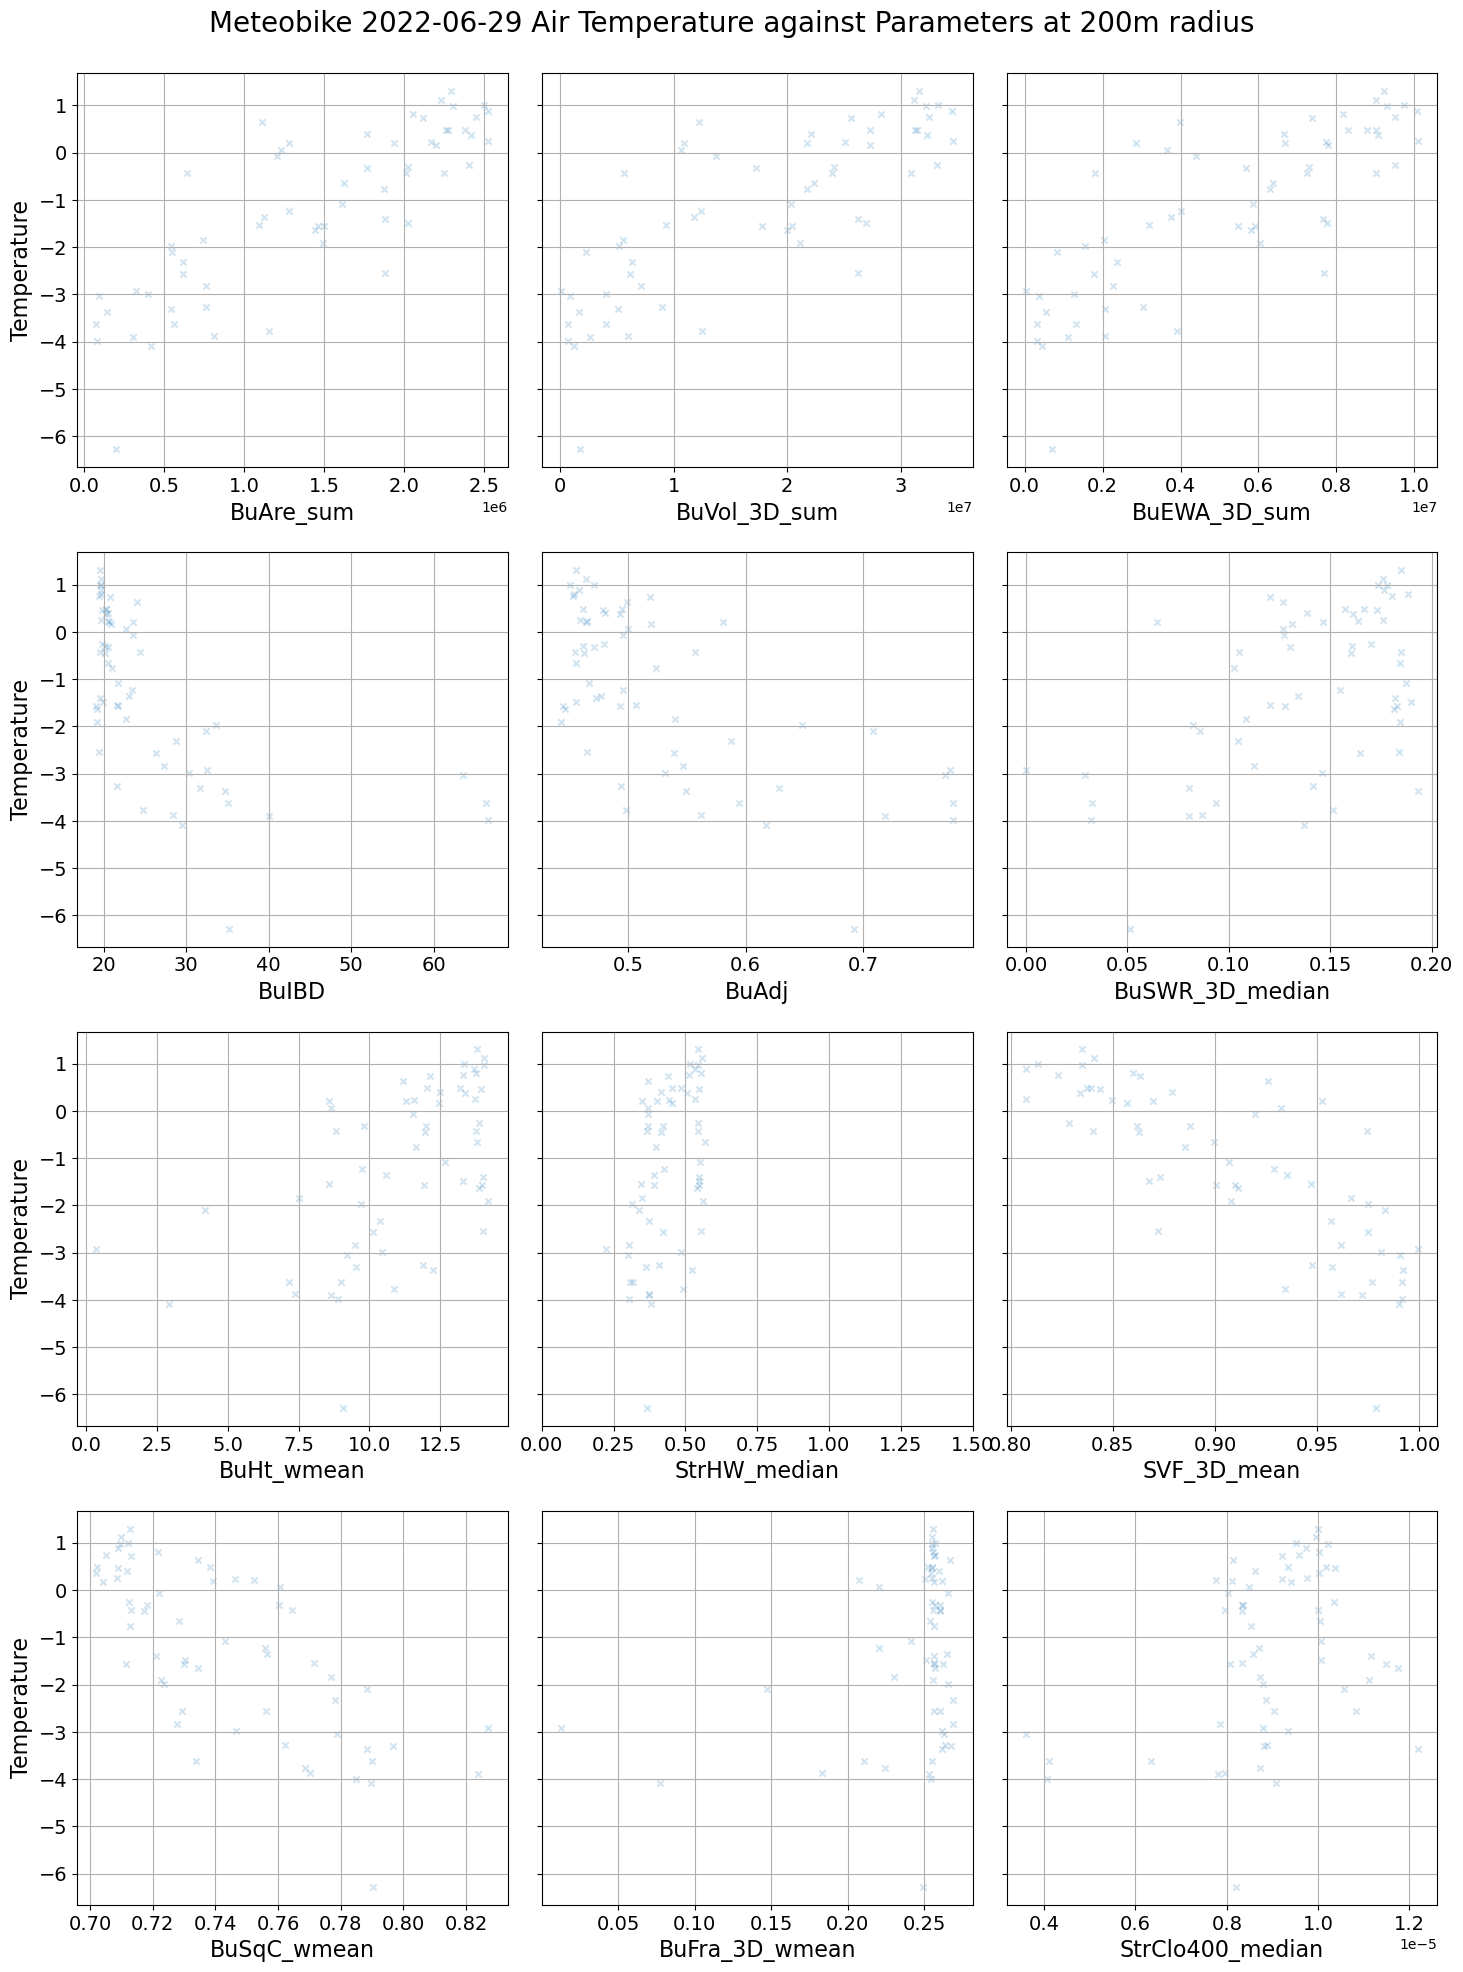

In [8]:
radii = [2000]

spearman_corr = {}

for radius in radii:
    print(radius)
    stn_buffers = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_processed_station_params_' + str(radius) + '.parquet')
    spearman_corr[radius] = {}

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle('Meteobike 2022-06-29 Air Temperature against Parameters at 200m radius', fontsize=20, y=0.99)
    #fig.subplots_adjust(wspace=0.1)
    for i, ax in enumerate(axs.flat):
        if params[i] == 'StrHW_median':
            stn_buffers[['StrHW_median','Temperature_diff_K']].plot(x='StrHW_median', y='Temperature_diff_K', ax=ax, kind='scatter',marker='x',xlim=(0,1.5),alpha=0.2)
        else:
            stn_buffers[[params[i],'Temperature_diff_K']].plot(x=params[i], y='Temperature_diff_K', ax=ax, kind='scatter',marker='x',alpha=0.2)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlabel(params[i],fontsize=16)
        ax.set_ylabel('Temperature',fontsize=16)
        ax.grid()

        if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
            ax.set_ylabel("")  # Remove y-axis label
            ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
            
    plt.tight_layout(pad = 2, w_pad=0.01)